In [83]:
pip install opendatasets

In [84]:
import opendatasets as od
import pandas as pd

od.download(
    "https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/",force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hardikgogia
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images


100%|██████████| 105M/105M [00:00<00:00, 1.28GB/s]

In [85]:
import os

data_dir = './cifake-real-and-ai-generated-synthetic-images'

for split in ['train', 'test']:
    for category in ['REAL', 'FAKE']:
        folder = os.path.join(data_dir, split, category)
        num_images = len(os.listdir(folder))
        print(f"{split}/{category}: {num_images} images")

train/REAL: 50000 images
train/FAKE: 50000 images
test/REAL: 10000 images
test/FAKE: 10000 images


In [86]:
import pandas as pd

def create_image_dataframe(data_dir):
    data = []
    for split in ['train', 'test']:
        for label in ['FAKE', 'REAL']:
            folder = os.path.join(data_dir, split, label)
            for filename in os.listdir(folder):
                data.append({
                    'path': os.path.join(folder, filename),
                    'label': label,
                    'split': split
                })
    return pd.DataFrame(data)

df = create_image_dataframe('./cifake-real-and-ai-generated-synthetic-images')


In [87]:
df.head()

,path,label,split
0,./cifake-real-and-ai-generated-synthetic-image...,FAKE,train
1,./cifake-real-and-ai-generated-synthetic-image...,FAKE,train
2,./cifake-real-and-ai-generated-synthetic-image...,FAKE,train
3,./cifake-real-and-ai-generated-synthetic-image...,FAKE,train
4,./cifake-real-and-ai-generated-synthetic-image...,FAKE,train


In [99]:
df['class'] = df['label'].map({'FAKE': 0, 'REAL': 1})

In [100]:
train_df = df[df['split']=='train'].copy()

In [101]:
test_df = df[df['split']=='test'].copy()

In [102]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,
    stratify=train_df['class']
)

In [93]:
def image_whitening(image):
    mean = np.mean(image)
    std = np.std(image)
    whitened_image = (image - mean) / std
    return whitened_image

def image_normalization(image):
    normalized_image = image / 255.0
    return normalized_image

In [104]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator with preprocessing functions
datagen = ImageDataGenerator(preprocessing_function=lambda x: image_whitening(image_normalization(x)))

# data generators
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='raw',
    shuffle=True
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='raw',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='class',
    target_size=(64, 64),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

Found 80000 validated image filenames.
Found 20000 validated image filenames.
Found 20000 validated image filenames.


In [105]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Add, MaxPooling2D, Dense, BatchNormalization, Input, Flatten, Dropout, LeakyReLU, AveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Define the CNN model
model = Sequential([
    Conv2D(26, (3, 3), input_shape=(64, 64, 3)),
    LeakyReLU(alpha=0.1),
    AveragePooling2D((2, 2)),
    Conv2D(32, (3, 3)),
    LeakyReLU(alpha=0.1),
    AveragePooling2D((2, 2)),
    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model using generators
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=20,
                    callbacks=[early_stopping],
                    verbose=1)

# Clear memory
import gc
gc.collect()

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - accuracy: 0.7246 - loss: 0.5269 - val_accuracy: 0.8792 - val_loss: 0.2950
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 56s 22ms/step - accuracy: 0.8861 - loss: 0.2793 - val_accuracy: 0.8528 - val_loss: 0.3337
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.9068 - loss: 0.2298 - val_accuracy: 0.9136 - val_loss: 0.2193
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - accuracy: 0.9188 - loss: 0.2037 - val_accuracy: 0.9202 - val_loss: 0.1992
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.9284 - loss: 0.1836 - val_accuracy: 0.9272 - val_loss: 0.1856
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.9336 - loss: 0.1710 - val_accuracy: 0.9237 - val_loss: 0.1884
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - accuracy: 0.9391 - loss: 0.1570 - val_accuracy: 0.9322 - val_loss: 0.1715
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.9432 - loss: 0.14

3663

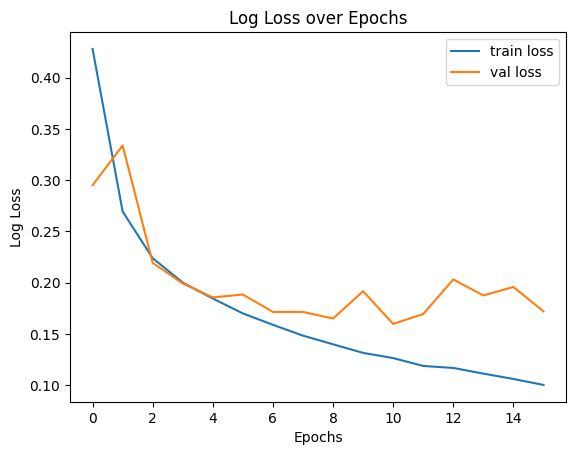

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9388 - loss: 0.1550
Test loss: 0.1539415419101715
Test accuracy: 0.9391000270843506


In [106]:
import matplotlib.pyplot as plt
# log loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.title('Log Loss over Epochs')
plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

In [107]:
from skimage.io import imread
from skimage.transform import resize

#image preprocessing functions
def preprocess_image(image_path, target_size=(64, 64)):
    image = imread(image_path)
    image_resized = resize(image, target_size, anti_aliasing=True)
    image_normalized = image_normalization(image_resized)
    image_whitened = image_whitening(image_normalized)
    return np.expand_dims(image_whitened, axis=0)  # Add batch dimension

#function to classify an image
def classify_image(image_path):
    preprocessed_image = preprocess_image(image_path)
    prediction = model.predict(preprocessed_image)
    prediction_score = model.predict(preprocessed_image)[0][0]
    label = 'REAL' if prediction_score > 0.5 else 'FAKE'
    confidence = prediction_score if label == 'REAL' else 1 - prediction_score
    return label, float(confidence)

# Example
image_path = '/content/wp4785046.jpg'
label, confidence = classify_image(image_path)
print(f"The image is classified as {label} with confidence {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
The image is classified as REAL with confidence 1.00


In [108]:
tf.keras.models.save_model(model,'my_modell2.hdf5')

In [109]:
import gradio as gr
# Load your trained model
model = load_model('/content/my_modell2.hdf5')

# image preprocessing functions
def preprocess_image(image, target_size=(64, 64)):
    img_resized = resize(image, target_size, anti_aliasing=True)
    img_normalized = image_normalization(img_resized)
    img_whitened = image_whitening(img_normalized)
    return np.expand_dims(img_whitened, axis=0)

# function to classify an image
def classify_image(image):
    preprocessed_image = preprocess_image(image)
    prediction = model.predict(preprocessed_image)[0][0]  # Float in [0,1]
    label = 'REAL' if prediction > 0.5 else 'FAKE'
    confidence = prediction if label == 'REAL' else 1 - prediction
    return label, float(confidence)

# Gradio interface
interface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="numpy", label="Upload Image"),
    outputs=[gr.Textbox(label="Class"), gr.Number(label="Confidence")],
    title="Image Classification",
    description="Upload an image to classify it as REAL or FAKE."
)

interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cab3baf481cb15304a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
